In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import folium
from folium.plugins import HeatMap
from sklearn.cluster import DBSCAN
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

In [2]:
print("Loading and preparing data...")
df = pd.read_csv("clean_combined.csv")

# Convert timestamp to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Calculate time difference in seconds for rate of change
time_diff = df['timestamp'].diff().dt.total_seconds()
df['time_diff'] = time_diff

# Handle potential division by zero or NaN in time difference
df['time_diff'] = df['time_diff'].replace(0, np.nan)
df['time_diff'] = df['time_diff'].fillna(df['time_diff'].median())

# Compute vehicle speed (km/h) from odometer changes
df['speed'] = df['odo'].diff() / df['time_diff'] * 3600  # convert to km/h
df['speed'] = df['speed'].fillna(0).clip(0, 150)  # clip unrealistic values

Loading and preparing data...


## 1. Load and Prepare Data

In [3]:
print("Loading and preparing data...")
df = pd.read_csv("clean_combined.csv")

# Convert timestamp to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# Calculate time difference in seconds for rate of change
time_diff = df['timestamp'].diff().dt.total_seconds()
df['time_diff'] = time_diff

# Handle potential division by zero or NaN in time difference
df['time_diff'] = df['time_diff'].replace(0, np.nan)
df['time_diff'] = df['time_diff'].fillna(df['time_diff'].median())

# Compute vehicle speed (km/h) from odometer changes
df['speed'] = df['odo'].diff() / df['time_diff'] * 3600  # convert to km/h
df['speed'] = df['speed'].fillna(0).clip(0, 150)  # clip unrealistic values

Loading and preparing data...


## 2. Detect Overcurrent Events using Multiple Methods

In [4]:
print("Detecting overcurrent events...")

# Method 1: Static threshold based on statistical properties
mean_current = df['i'].mean()
std_current = df['i'].std()
static_threshold = mean_current + 3 * std_current
df['overcurrent_static'] = df['i'] > static_threshold

# Method 2: Rate of change detection
df['di_dt'] = df['i'].diff() / df['time_diff']
roc_mean = df['di_dt'].mean()
roc_std = df['di_dt'].std()
roc_threshold = roc_mean + 3 * roc_std
df['overcurrent_rate'] = df['di_dt'] > roc_threshold

# Combined detection (either method flags it)
df['overcurrent'] = (df['overcurrent_static'] | df['overcurrent_rate'])

# Print summary statistics
total_events = df['overcurrent'].sum()
static_events = df['overcurrent_static'].sum()
rate_events = df['overcurrent_rate'].sum()

print(f"Total overcurrent events detected: {total_events}")
print(f"  - Static threshold method: {static_events}")
print(f"  - Rate of change method: {rate_events}")

Detecting overcurrent events...
Total overcurrent events detected: 2959
  - Static threshold method: 1744
  - Rate of change method: 1323


## 3. Visualize Current Values and Thresholds

Creating visualizations...


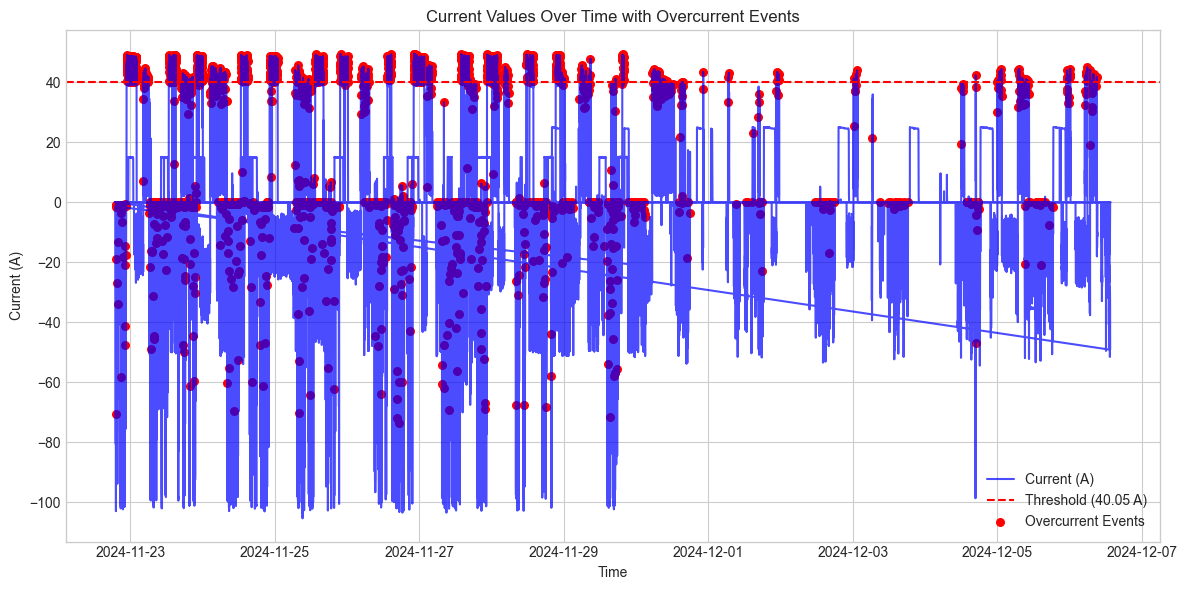

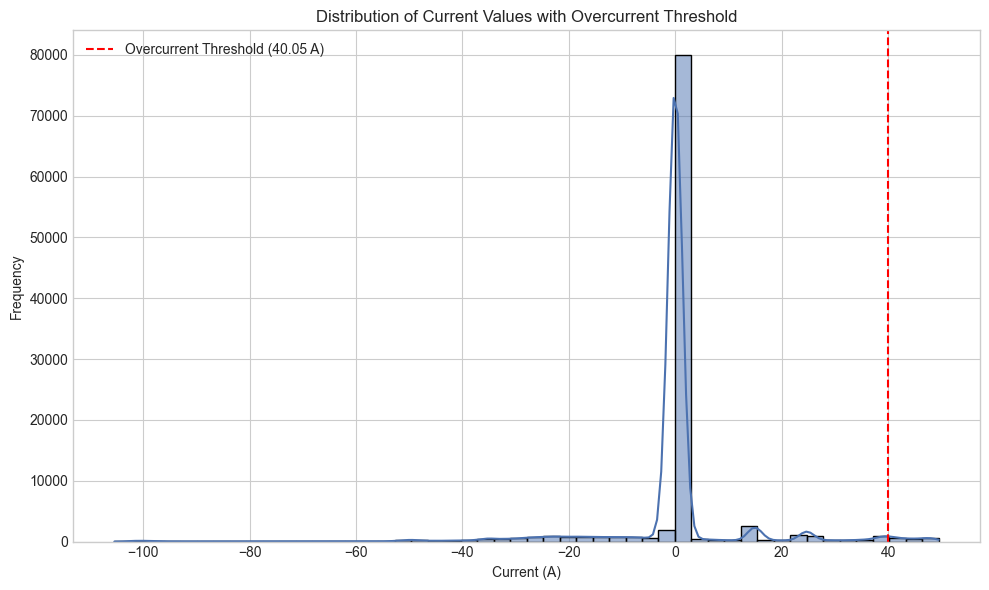

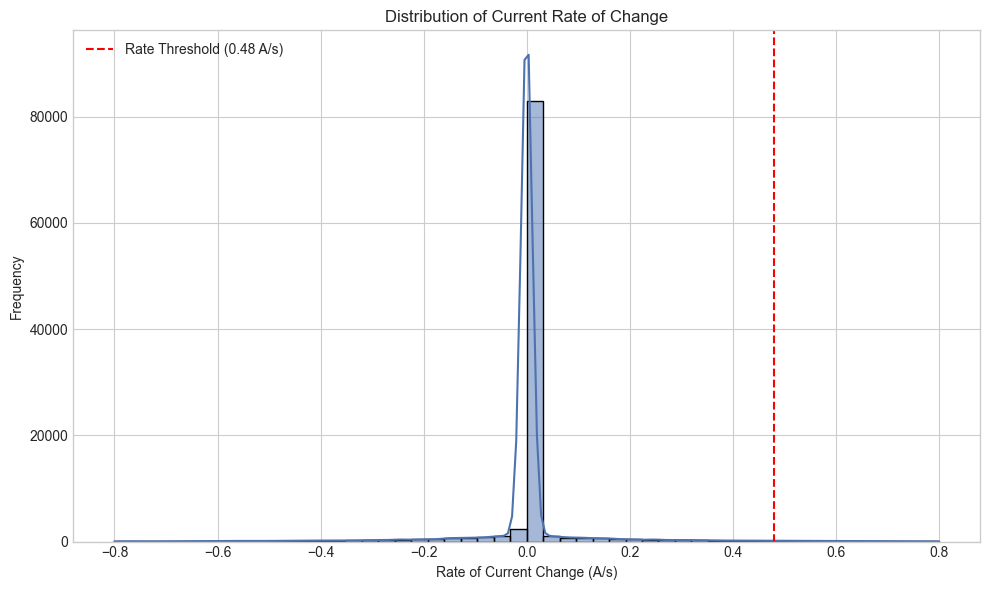

In [5]:
print("Creating visualizations...")

# Plot 1: Time series of current with threshold
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['i'], 'b-', alpha=0.7, label='Current (A)')
plt.axhline(y=static_threshold, color='r', linestyle='--', label=f'Threshold ({static_threshold:.2f} A)')
# Mark overcurrent events
plt.scatter(df[df['overcurrent']]['timestamp'], 
           df[df['overcurrent']]['i'], 
           color='red', label='Overcurrent Events', s=30)
plt.ylabel('Current (A)')
plt.xlabel('Time')
plt.title('Current Values Over Time with Overcurrent Events')
plt.legend()
plt.tight_layout()
plt.savefig('current_time_series.png')

# Plot 2: Distribution of current values
plt.figure(figsize=(10, 6))
sns.histplot(df['i'], bins=50, kde=True)
plt.axvline(x=static_threshold, color='r', linestyle='--', 
           label=f'Overcurrent Threshold ({static_threshold:.2f} A)')
plt.xlabel('Current (A)')
plt.ylabel('Frequency')
plt.title('Distribution of Current Values with Overcurrent Threshold')
plt.legend()
plt.tight_layout()
plt.savefig('current_distribution.png')
# Plot 3: Distribution of current rate of change
plt.figure(figsize=(10, 6))
# Filter extreme values for better visualization
filtered_di_dt = df['di_dt'][(df['di_dt'] > roc_mean - 5*roc_std) & 
                           (df['di_dt'] < roc_mean + 5*roc_std)]
sns.histplot(filtered_di_dt, bins=50, kde=True)
plt.axvline(x=roc_threshold, color='r', linestyle='--', 
           label=f'Rate Threshold ({roc_threshold:.2f} A/s)')
plt.xlabel('Rate of Current Change (A/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Current Rate of Change')
plt.legend()
plt.tight_layout()
plt.savefig('current_rate_distribution.png')


## 4. Temporal Analysis

Performing temporal analysis...


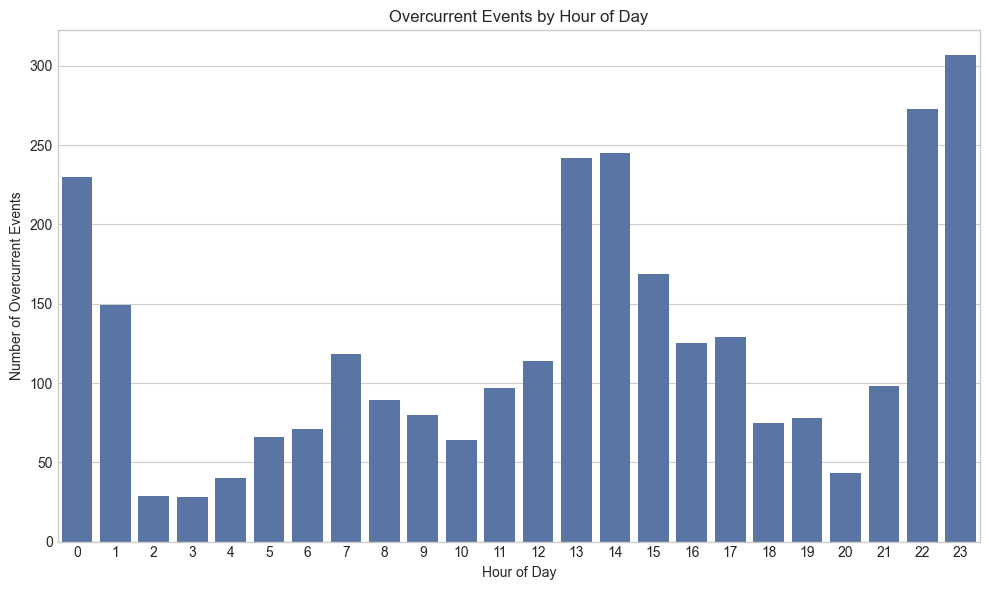

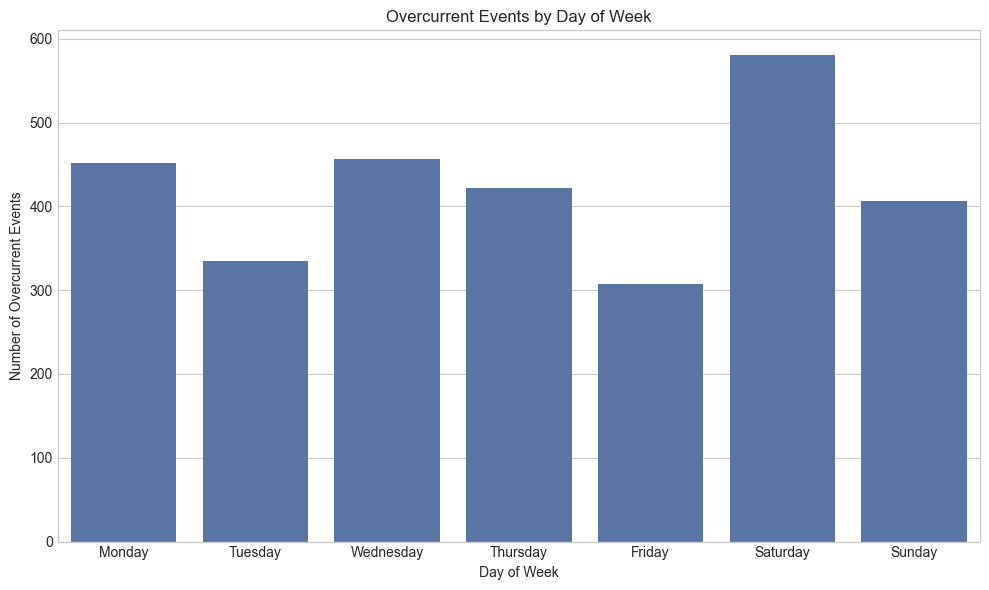

In [6]:
print("Performing temporal analysis...")

# When do overcurrent events occur?
df_events = df[df['overcurrent']]

# Plot 4: Overcurrent events by hour of day
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df_events)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Overcurrent Events')
plt.title('Overcurrent Events by Hour of Day')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig('events_by_hour.png')

# Plot 5: Overcurrent events by day of week
plt.figure(figsize=(10, 6))
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='day_of_week', data=df_events)
plt.xlabel('Day of Week')
plt.ylabel('Number of Overcurrent Events')
plt.title('Overcurrent Events by Day of Week')
plt.xticks(range(7), day_names)
plt.tight_layout()
plt.savefig('events_by_day.png')

## 5. Geographical Analysis

In [7]:
print("Performing geographical analysis...")

# Create map centered on average location
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)

# Add markers for overcurrent events
for _, row in df_events.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"Current: {row['i']:.2f}A, Time: {row['timestamp']}"
    ).add_to(m)

# Add heatmap layer
event_locations = df_events[['lat', 'lon']].values.tolist()
HeatMap(event_locations).add_to(m)

# Save map
m.save('overcurrent_locations.html')

# Try clustering event locations
coords = df_events[['lat', 'lon']].values
# DBSCAN clustering to find clusters of events
if len(coords) > 1:  # Only run if we have events
    # Increase eps parameter to create fewer, more meaningful clusters
    db = DBSCAN(eps=0.005, min_samples=2).fit(coords)  # Increased eps from 0.001 to 0.005
    labels = db.labels_
    
    # Number of clusters (excluding noise if any)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Number of geographical clusters of events: {n_clusters}")
    
    # Add cluster information to events dataframe - use .loc to avoid the SettingWithCopyWarning
    df_events = df_events.copy()  # Create an explicit copy to avoid the warning
    df_events.loc[:, 'cluster'] = labels
    
    # Create a map with clusters colored
    m_clusters = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=12)
    
    # Define color map for clusters
    colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen']
    
    # Add markers with cluster colors
    for _, row in df_events.iterrows():
        if row['cluster'] == -1:  # Noise points
            color = 'gray'
        else:
            color = colors[row['cluster'] % len(colors)]
            
        folium.CircleMarker(
            location=[row['lat'], row['lon']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"Current: {row['i']:.2f}A, Cluster: {row['cluster']}"
        ).add_to(m_clusters)
    
    m_clusters.save('overcurrent_clusters.html')

Performing geographical analysis...
Number of geographical clusters of events: 38


## 6. Feature Correlation Analysis

Analyzing feature correlations...


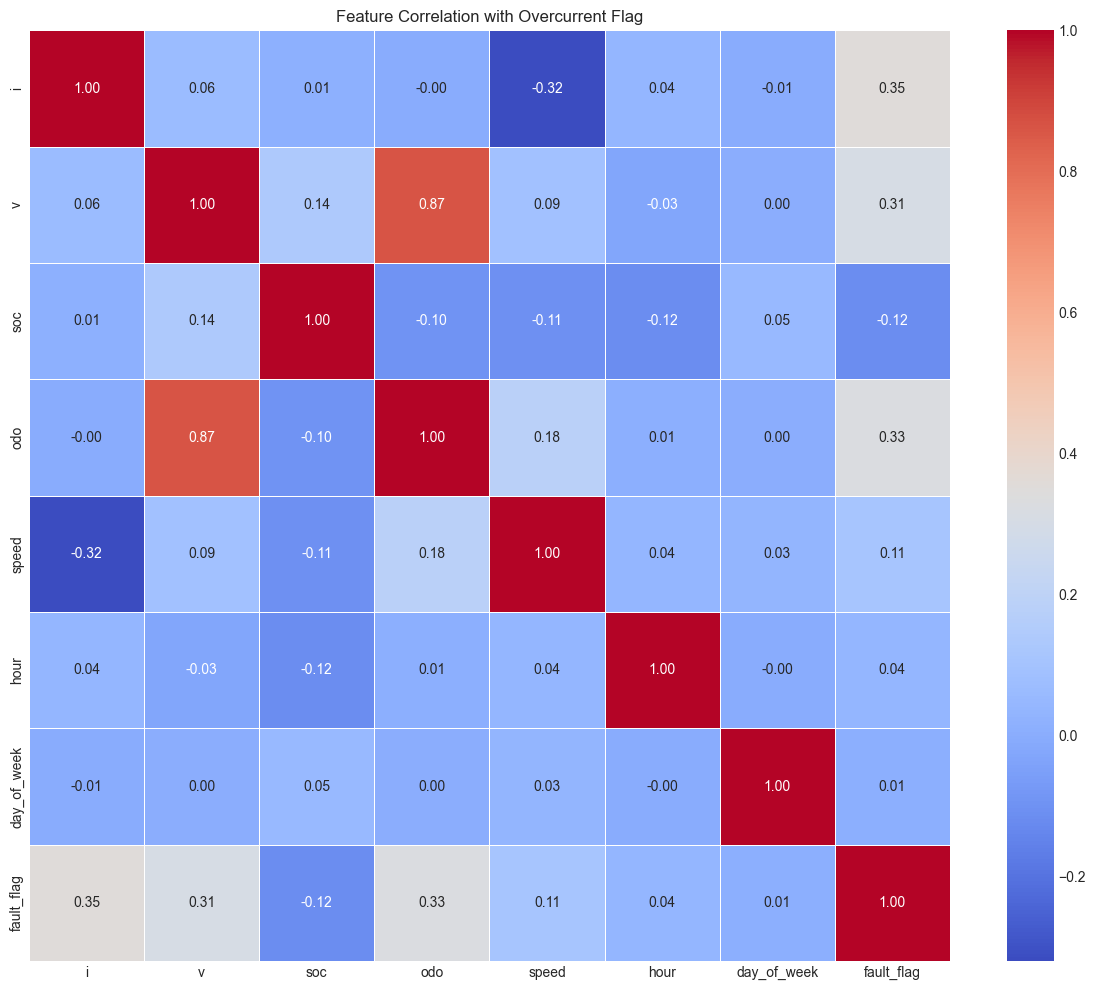

In [8]:
print("Analyzing feature correlations...")

# Add numerical flag for correlation
df['fault_flag'] = df['overcurrent'].astype(int)

# Select relevant features
corr_features = ['i', 'v', 'soc', 'odo', 'speed', 'hour', 'day_of_week', 'fault_flag']
corr_df = df[corr_features].copy()

# Calculate correlation matrix
corr = corr_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation with Overcurrent Flag")
plt.tight_layout()
plt.savefig('correlation_heatmap.png')

## 7. Predictive Modeling

Building predictive model...
Cross-validation F1 scores: [0.00674536 0.00211274 0.71028037 0.12082983 0.05949151]
Mean CV F1 score: 0.180 ± 0.269

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19408
           1       0.89      0.62      0.73       592

    accuracy                           0.99     20000
   macro avg       0.94      0.81      0.86     20000
weighted avg       0.99      0.99      0.99     20000


Feature Importance:
       Feature  Importance
1            i    0.330170
0            v    0.204257
3          odo    0.188857
2          soc    0.160686
4        speed    0.079424
5         hour    0.026936
6  day_of_week    0.009670


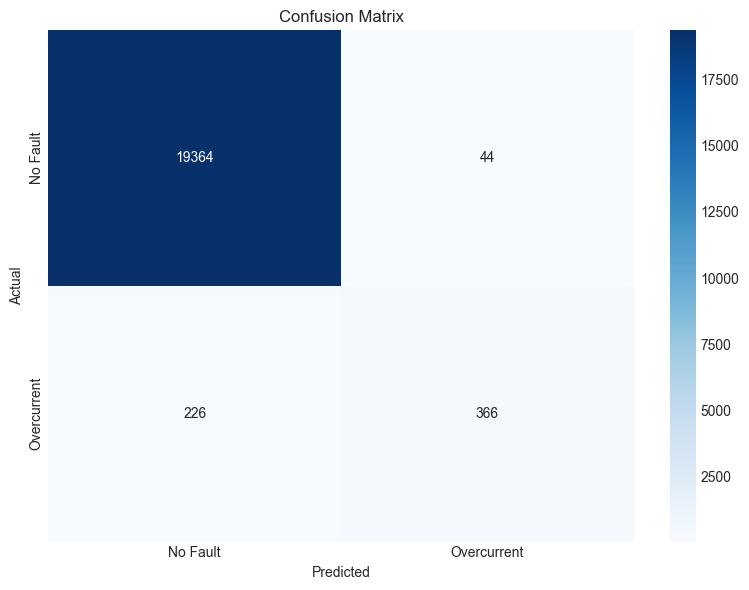

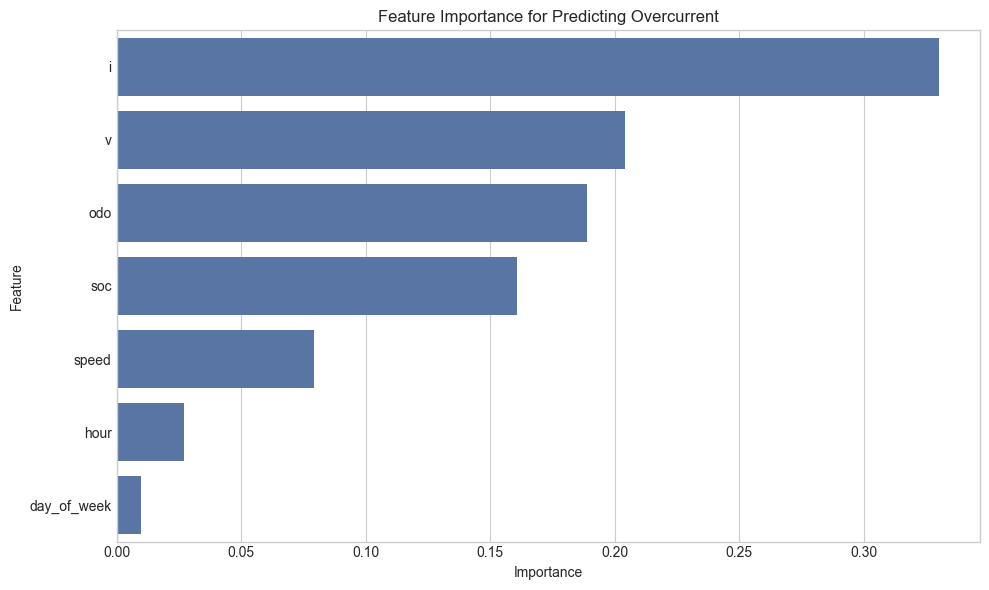

In [9]:
print("Building predictive model...")

# Prepare features and target
features = df[['v', 'i', 'soc', 'odo', 'speed', 'hour', 'day_of_week']].bfill()
target = df['fault_flag']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target
)

# Train Random Forest model
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate with cross-validation
cv_scores = cross_val_score(model, features, target, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Make predictions on test set
y_pred = model.predict(X_test)

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Fault', 'Overcurrent'],
           yticklabels=['No Fault', 'Overcurrent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')

# Feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Predicting Overcurrent')
plt.tight_layout()
plt.savefig('feature_importance.png')

## 8. Summary & Insights

In [10]:
print("\n--- SUMMARY OF FINDINGS ---")
print(f"Total overcurrent events: {total_events} out of {len(df)} records ({total_events/len(df)*100:.2f}%)")

if total_events > 0:
    # Top locations with overcurrent
    if 'cluster' in df_events.columns:
        top_clusters = df_events['cluster'].value_counts().head(3)
        print("\nTop 3 geographical clusters with overcurrent events:")
        print(top_clusters)
    
    # Time patterns
    peak_hour = df_events['hour'].value_counts().idxmax()
    print(f"\nPeak hour for overcurrent events: {peak_hour}:00")
    
    # Associated conditions
    avg_soc = df_events['soc'].mean()
    avg_speed = df_events['speed'].mean()
    print(f"\nAverage conditions during overcurrent events:")
    print(f"- State of Charge: {avg_soc:.1f}%")
    print(f"- Speed: {avg_speed:.1f} km/h")
    
    # Most important predictive features
    print(f"\nTop 3 predictive features for overcurrent:")
    for _, row in feature_importance.head(3).iterrows():
        print(f"- {row['Feature']}: {row['Importance']:.3f}")

print("\nRECOMMENDATIONS:")
print("1. Monitor battery current closely during high-speed operation")
print("2. Implement early warning system based on predictive model")
print("3. Investigate geographical clusters for environmental factors")
print("\nAnalysis completed successfully")


--- SUMMARY OF FINDINGS ---
Total overcurrent events: 2959 out of 100000 records (2.96%)

Top 3 geographical clusters with overcurrent events:
cluster
20    1923
9      508
10     231
Name: count, dtype: int64

Peak hour for overcurrent events: 23:00

Average conditions during overcurrent events:
- State of Charge: 67.5%
- Speed: 5.6 km/h

Top 3 predictive features for overcurrent:
- i: 0.330
- v: 0.204
- odo: 0.189

RECOMMENDATIONS:
1. Monitor battery current closely during high-speed operation
2. Implement early warning system based on predictive model
3. Investigate geographical clusters for environmental factors

Analysis completed successfully
